# 用二分类做，效果并不好

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
C:\Users\dell\anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dell\anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dell\anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dell\anaconda3\envs\pytorch\lib\sit

In [2]:
# read the data
dataset = pd.read_csv('20_year_FD.csv')
dataset.head()

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,amount,label
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,1111793.167,False
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,394141.216,True
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,446597.972,True
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,164467.462,False
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,180573.596,False


### 特征工程

In [3]:
import talib as ta

In [4]:
ta.MA(dataset.close.to_numpy(),timeperiod=10,matype=0)

array([   nan,    nan,    nan, ..., 3.5021, 3.5009, 3.4916])

#### 根据收盘价close构建特征

In [5]:
types=['SMA','EMA','WMA','DEMA','TEMA',
'TRIMA','KAMA','MAMA','T3']
for i in range(len(types)):
    dataset[types[i]]=ta.MA(dataset.close.to_numpy(),timeperiod=10,matype=i)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,label,SMA,EMA,WMA,DEMA,TEMA,TRIMA,KAMA,MAMA,T3
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,False,3.5190,3.504778,3.514382,3.513304,3.498623,3.528200,3.461945,3.502220,3.529209
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,False,3.5149,3.495909,3.502927,3.495628,3.476412,3.523200,3.461833,3.499909,3.528766
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,False,3.5021,3.483744,3.487309,3.473561,3.449736,3.513033,3.458546,3.492094,3.524939
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,True,3.5009,3.479609,3.479836,3.467894,3.447148,3.501667,3.458567,3.476547,3.518941


In [6]:
#布林带计算
H_line,M_line,L_line=ta.BBANDS(dataset.close.to_numpy(), timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
dataset['H_line']=H_line
dataset['M_line']=M_line
dataset['L_line']=L_line
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,WMA,DEMA,TEMA,TRIMA,KAMA,MAMA,T3,H_line,M_line,L_line
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.514382,3.513304,3.498623,3.528200,3.461945,3.502220,3.529209,3.582138,3.5190,3.455862
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.502927,3.495628,3.476412,3.523200,3.461833,3.499909,3.528766,3.587791,3.5149,3.442009
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.487309,3.473561,3.449736,3.513033,3.458546,3.492094,3.524939,3.585168,3.5021,3.419032
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.479836,3.467894,3.447148,3.501667,3.458567,3.476547,3.518941,3.585939,3.5009,3.415861


In [7]:
dataset = dataset.dropna(how='any')
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,WMA,DEMA,TEMA,TRIMA,KAMA,MAMA,T3,H_line,M_line,L_line
54,510050.SH,20050517,0.750,0.750,0.760,0.746,0.754,0.004,0.5333,1184261.70,...,0.766345,0.754968,0.750896,0.774867,0.775437,0.770325,0.776893,0.804643,0.7739,0.743157
55,510050.SH,20050518,0.754,0.752,0.761,0.747,0.755,0.001,0.1326,1444553.14,...,0.762909,0.752602,0.749706,0.769700,0.773013,0.762662,0.772424,0.801664,0.7706,0.739536
56,510050.SH,20050519,0.755,0.754,0.759,0.746,0.755,0.000,0.0000,1498215.63,...,0.760073,0.751098,0.749438,0.764733,0.768993,0.762279,0.768130,0.793101,0.7664,0.739699
57,510050.SH,20050520,0.755,0.754,0.760,0.752,0.757,0.002,0.2649,1476985.07,...,0.758364,0.750881,0.750635,0.760833,0.767036,0.762015,0.764217,0.786174,0.7633,0.740426
58,510050.SH,20050523,0.757,0.753,0.753,0.742,0.743,-0.014,-1.8494,2472999.69,...,0.754673,0.746310,0.745507,0.757567,0.762597,0.761064,0.760473,0.782442,0.7596,0.736758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.514382,3.513304,3.498623,3.528200,3.461945,3.502220,3.529209,3.582138,3.5190,3.455862
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.502927,3.495628,3.476412,3.523200,3.461833,3.499909,3.528766,3.587791,3.5149,3.442009
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.487309,3.473561,3.449736,3.513033,3.458546,3.492094,3.524939,3.585168,3.5021,3.419032
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.479836,3.467894,3.447148,3.501667,3.458567,3.476547,3.518941,3.585939,3.5009,3.415861


In [8]:
dataset[:2015].iloc[0,2:-1].values.astype('float')

array([7.50000000e-01, 7.50000000e-01, 7.60000000e-01, 7.46000000e-01,
       7.54000000e-01, 4.00000000e-03, 5.33300000e-01, 1.18426170e+06,
       8.93624410e+04, 1.00000000e+00, 7.73900000e-01, 7.70942874e-01,
       7.66345455e-01, 7.54968362e-01, 7.50896028e-01, 7.74866667e-01,
       7.75437249e-01, 7.70324553e-01, 7.76893311e-01, 8.04643455e-01,
       7.73900000e-01])

In [9]:
features = dataset.drop(labels = ['label','ts_code','trade_date'], axis = 1)
label = dataset.label

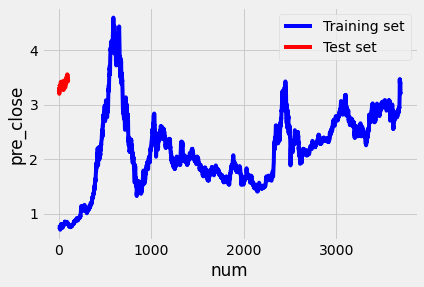

In [10]:
training_set = features[:-100].values.astype('float')
test_set = features[-100:].values.astype('float')
train_label = label[:-100].values.astype('int')
test_label = label[-100:].values.astype('int')

plt.plot(training_set[:,0], color='blue', label='Training set')
plt.plot(test_set[:,0], color='red', label='Test set')
plt.xlabel('num')
plt.ylabel('pre_close')
plt.legend()
plt.show()

In [11]:
sum(test_label)/len(test_label)

0.49

In [12]:
# scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
time_step = 5
# create a data structure with 60 timesteps and 1 output, 
# so for each element of training set, there are 60 previous training set elements
X_train = [] # feature
y_train = [] # lable
# training_set length is 7056, it is the total days between 1990-01-01 and 2017-12-29, also is the rows in the csv file
for i in range(time_step, len(training_set)):
    X_train.append(training_set_scaled[(i-time_step):i,:])
    y_train.append(train_label[i])
X_train, y_train = np.array(X_train), np.array(y_train)


In [13]:
sum(y_train)

1972

In [14]:
# LSTM
classifier = Sequential()
# firt LSTM layer
classifier.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
classifier.add(Dropout(0.2))
# second LSTM layer
classifier.add(LSTM(units=50, return_sequences=True))
classifier.add(Dropout(0.2))
# third LSTM layer
classifier.add(LSTM(units=50, return_sequences=True))
classifier.add(Dropout(0.2))
# fourth LSTM layer
classifier.add(LSTM(units=50))
classifier.add(Dropout(0.2))
# output layer

classifier.add(Dense(units=10,activation='relu'))
classifier.add(Dense(units=1))
# compile the RNN
classifier.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# fit to the training set
classifier.fit(X_train, y_train, epochs=50, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
3689/3689 [==============================] - 6s 2ms/step - loss: 0.8748 - accuracy: 0.4784
Epoch 2/50
3689/3689 [==============================] - 3s 766us/step - loss: 0.7064 - accuracy: 0.4917
Epoch 3/50
3689/3689 [==============================] - 3s 751us/step - loss: 0.7014 - accuracy: 0.5134
Epoch 4/50
3689/3689 [==============================] - 3s 761us/step - loss: 0.7027 - accuracy: 0.4958
Epoch 5/50
3689/3689 [==============================] - 3s 758us/step - loss: 0.6987 - accuracy: 0.5164
Epoch 6/50
3689/3689 [==============================] - 3s 758us/step - loss: 0.6955 - accuracy: 0.5194
Epoch 7/50
3689/3689 [==============================] - 3s 757us/step - loss: 0.6949 - accuracy: 0.5172
Epoch 8/50
3689/3689 [==============================] - 3s 740us/step - loss: 0.6962 - accuracy: 0.5083
Epoch 9/50
3689/3689 [==============================] - 3s 755us/step - los

In [17]:
# scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc.fit_transform(test_set)
time_step = 5
# create a data structure with 60 timesteps and 1 output, 
# so for each element of training set, there are 60 previous training set elements
X_test = [] # feature
y_test = [] # lable
# training_set length is 7056, it is the total days between 1990-01-01 and 2017-12-29, also is the rows in the csv file
for i in range(time_step, len(test_set)):
    X_test.append(test_set_scaled[(i-time_step):i,:])
    y_test.append(test_label[i])
X_test, y_test = np.array(X_test), np.array(y_test)


In [18]:
y_pre = classifier.predict(X_test)
y_pre.shape

(95, 1)

In [19]:
y_pre = y_pre>0.5
y_pre

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [20]:
y_pre = np.squeeze(y_pre)
y_pre.shape

(95,)

In [ ]:
print(sum(y_pre==y_test)/len(y_test))

In [ ]:
# training set + test set, total is 7279, training_set is 7056, test_set is 222
dataset_total = pd.concat((dataset['High'][:'2017-12-29'], dataset['High']['2018-01-02':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
X_test = []
for i in range(60, 282):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
LSTM_predicted_stock_price = regressor.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

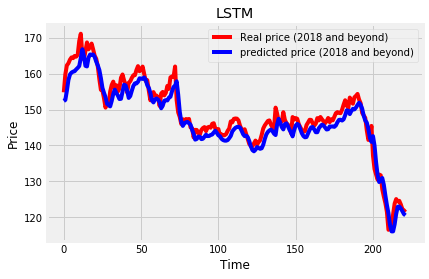

In [158]:
plt.plot(test_set, color='red', label='Real price (2018 and beyond)')
plt.plot(LSTM_predicted_stock_price, color='blue', label='predicted price (2018 and beyond)')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [57]:
LSTM_rmse = mean_squared_error(test_set, LSTM_predicted_stock_price)
print ("root mean squared error is {}.".format(LSTM_rmse))


root mean squared error is 8.112332664725722.


In [44]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1,activation='sigmoid'))
regressorGRU.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
regressorGRU.fit(X_train, y_train, epochs=50, batch_size=32)

# serialize model to JSON
model_json = regressorGRU.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
regressorGRU.save_weights("model.h5")
print("Saved model to disk")


Epoch 1/50
1955/1955 [==============================] - 10s 5ms/step - loss: 0.6957 - accuracy: 0.5192
Epoch 2/50
1955/1955 [==============================] - 9s 5ms/step - loss: 0.6940 - accuracy: 0.5202
Epoch 3/50
1955/1955 [==============================] - 9s 5ms/step - loss: 0.6916 - accuracy: 0.5299
Epoch 4/50
1955/1955 [==============================] - 9s 5ms/step - loss: 0.6900 - accuracy: 0.5304
Epoch 5/50
1955/1955 [==============================] - 11s 6ms/step - loss: 0.6906 - accuracy: 0.5315
Epoch 6/50
1955/1955 [==============================] - 11s 6ms/step - loss: 0.6918 - accuracy: 0.5361
Epoch 7/50
1955/1955 [==============================] - 9s 5ms/step - loss: 0.6901 - accuracy: 0.5289
Epoch 8/50
1955/1955 [==============================] - 10s 5ms/step - loss: 0.6894 - accuracy: 0.5253
Epoch 9/50
1955/1955 [==============================] - 10s 5ms/step - loss: 0.6898 - accuracy: 0.5304
Epoch 10/50
1955/1955 [==============================] - 9s 5ms/step - loss: 

In [45]:
y_pre = regressorGRU.predict(X_test)
y_pre = y_pre>0.5
y_pre = np.squeeze(y_pre)
print(sum(y_pre==y_test)/len(y_test))

0.5228267667292058


In [58]:
X_test = []
for i in range(60, 282):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

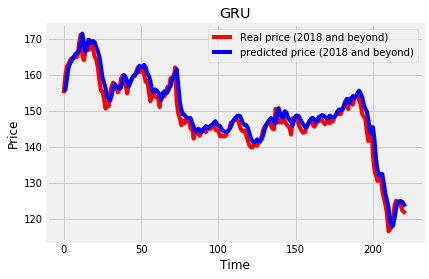

In [59]:
plt.plot(test_set, color='red', label='Real price (2018 and beyond)')
plt.plot(GRU_predicted_stock_price, color='blue', label='predicted price (2018 and beyond)')
plt.title('GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [60]:
GRU_rmse = math.sqrt(mean_squared_error(test_set, GRU_predicted_stock_price))
print ("root mean squared error is {}.".format(GRU_rmse))

root mean squared error is 2.6047938849174863.


In [61]:
# BiLSTM
regressorBiLSTM = Sequential()
# firt LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1],X_train.shape[2]), merge_mode='concat'))
regressorBiLSTM.add(Dropout(0.2))
# second LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# third LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# fourth LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50)))
regressorBiLSTM.add(Dropout(0.2))
# output layer
regressorBiLSTM.add(Dense(units=1))
# compile the RNN
regressorBiLSTM.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressorBiLSTM.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
6996/6996 [==============================] - 308s 44ms/step - loss: 0.0113
Epoch 2/50
6996/6996 [==============================] - 298s 43ms/step - loss: 0.0042
Epoch 3/50
6996/6996 [==============================] - 300s 43ms/step - loss: 0.0031
Epoch 4/50
6996/6996 [==============================] - 299s 43ms/step - loss: 0.0025
Epoch 5/50
6996/6996 [==============================] - 300s 43ms/step - loss: 0.0022
Epoch 6/50
6996/6996 [==============================] - 298s 43ms/step - loss: 0.0019
Epoch 7/50
6996/6996 [==============================] - 298s 43ms/step - loss: 0.0018
Epoch 8/50
6996/6996 [==============================] - 299s 43ms/step - loss: 0.0017
Epoch 9/50
6996/6996 [==============================] - 298s 43ms/step - loss: 0.0016
Epoch 10/50
6996/6996 [==============================] - 298s 43ms/step - loss: 0.0014
Epoch 11/50
6996/6996 [==============================] - 298s 43ms/step - loss: 0.0015
Epoch 12/50
6996/6996 [=============================

In [63]:
X_test = []
for i in range(60, 282):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
BiLSTM_predicted_stock_price = regressorBiLSTM.predict(X_test)
BiLSTM_predicted_stock_price = sc.inverse_transform(BiLSTM_predicted_stock_price)

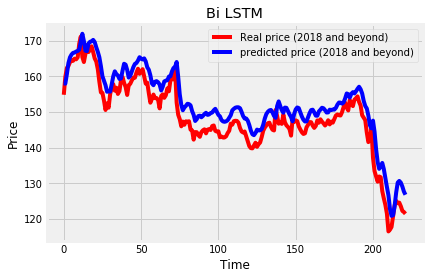

In [64]:
plt.plot(test_set, color='red', label='Real price (2018 and beyond)')
plt.plot(BiLSTM_predicted_stock_price, color='blue', label='predicted price (2018 and beyond)')
plt.title('Bi LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [65]:
BiLSTM_rmse = math.sqrt(mean_squared_error(test_set, BiLSTM_predicted_stock_price))
print ("root mean squared error is {}.".format(BiLSTM_rmse))

root mean squared error is 4.504284402842843.
